## ARIMA Notebook

*currently in-process*

In [30]:
# Data Manipulation
# ======================================================================================
import numpy as np
import pandas as pd
from os import path
import configparser
from itertools import *
import math
from epiweeks import Week
from datetime import date, datetime
from calendar import month_name, month_abbr

# Statistics
# ======================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling & Forecasting
# ======================================================
from pmdarima import ARIMA
from pmdarima import auto_arima

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

# Plotting
# ======================================================
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Reading Secrets
# ======================================================
cfg = configparser.ConfigParser()
cfg.read('secrets.ini')
ROOT_PATH = path.abspath(cfg.get('default','root'))
DATA_PATH = path.join(ROOT_PATH, 'src/data')


# Warnings Config
# ======================================================
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Loading & Manipulating Dataset
# ======================================================

df = pd.read_csv(path.join(DATA_PATH, 'raw_dataset.csv'))
df['epiweek'] = df['epiweek'].map(lambda x: Week.fromstring(str(x)))
df['weekstart'] = pd.to_datetime(df['epiweek'].map(lambda x: Week.startdate(x)))
df.set_index('weekstart', inplace=True)
df['epiweek'] = df['epiweek'].map(lambda x: int(str(x)[4:]))

# Checking dataset for missing values
df.isna().sum()

epiweek                0
GS_cold                0
GS_cough               0
GS_fever               0
GS_flu                 0
AWND                   0
PRCP                   0
SNOW                   0
TAVG                 398
TMAX                   0
TMIN                   0
cases                  0
Overall AQI Value      0
Main Pollutant         0
CO                    26
Ozone                113
PM10                  24
PM25                   0
Days Good              0
Days Moderate          0
Days Unhealthy         0
visits                79
dtype: int64

In [32]:
means = df[['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
            'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
            'cases', 'Overall AQI Value',
            'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
            'Days Moderate', 'Days Unhealthy', 'visits']] \
                .groupby(df.index.month).mean()

means.index.name = 'month'
df['month'] = df.index.month
df = df.reset_index().set_index(['weekstart','month'])

df[
    ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
    'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
    'cases', 'Overall AQI Value',
    'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
    'Days Moderate', 'Days Unhealthy', 'visits']
    
    ] = df[
        ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
        'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
        'cases', 'Overall AQI Value',
        'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
        'Days Moderate', 'Days Unhealthy', 'visits']]\
            .fillna(means)

df['TAVG'] = df[['TAVG']].fillna(
                pd.DataFrame(
                    (df['TMAX']+df['TMIN'])/2).rename(columns={0:'TAVG'}))

# Resampling data so pandas understands that it's weekly
df = df.reset_index() \
        .set_index('weekstart') \
        .drop(columns=['month']) \
        .resample('W').first().fillna(method='bfill')
df = df.drop(columns=['Main Pollutant'])

In [33]:
end_train = date(2015,12,31)
end_validation = date(2017,12,31)

df_train = df.loc[:end_train,:]
df_val = df.loc[end_train:end_validation,:]
df_test = df.loc[end_validation:,:]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2004-12-26 00:00:00 --- 2015-12-27 00:00:00  (n=575)
Dates validacion : 2016-01-03 00:00:00 --- 2017-12-31 00:00:00  (n=105)
Dates test       : 2017-12-31 00:00:00 --- 2019-12-29 00:00:00  (n=105)


In [37]:
# Test stationarity
# ==============================================================================

df_diff_1 = df_train.diff().dropna()
df_diff_2 = df_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(df['cases'])
kpss_result = kpss(df['cases'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_1['cases'])
kpss_result = kpss(df['cases'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_2['cases'])
kpss_result = kpss(df['cases'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')



Test stationarity for original series
-------------------------------------
ADF Statistic: -7.242490003657792, p-value: 1.8685892987574114e-10
KPSS Statistic: 0.10707193777368336, p-value: 0.1

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -10.45984125623637, p-value: 1.3681278863245903e-18
KPSS Statistic: 0.03382321558996888, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -9.89009028460463, p-value: 3.5770454895147435e-17
KPSS Statistic: 0.05374553562444671, p-value: 0.1


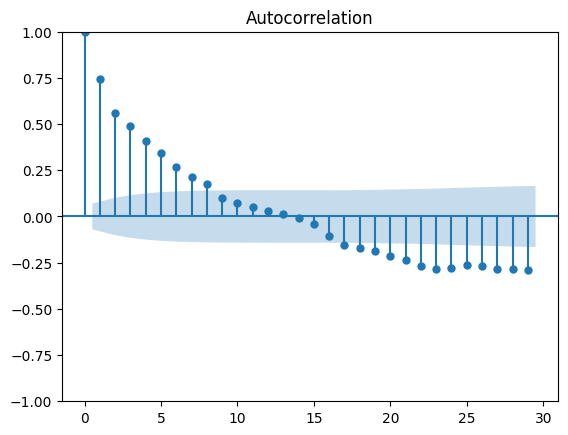

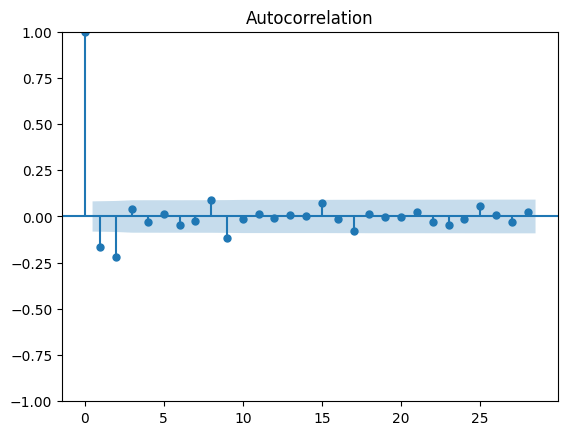

In [38]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
plot_acf(df['cases']).show()
plot_acf(df_diff_1['cases']).show()

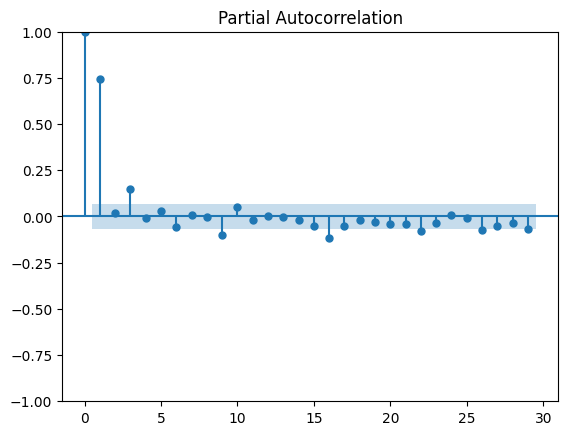

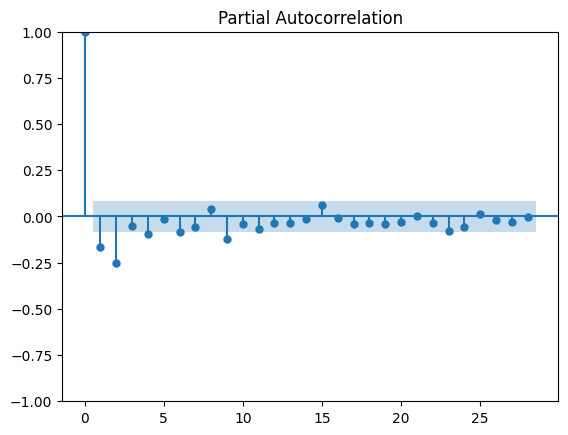

In [39]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
plot_pacf(df['cases']).show()
plot_pacf(df_diff_1['cases']).show()

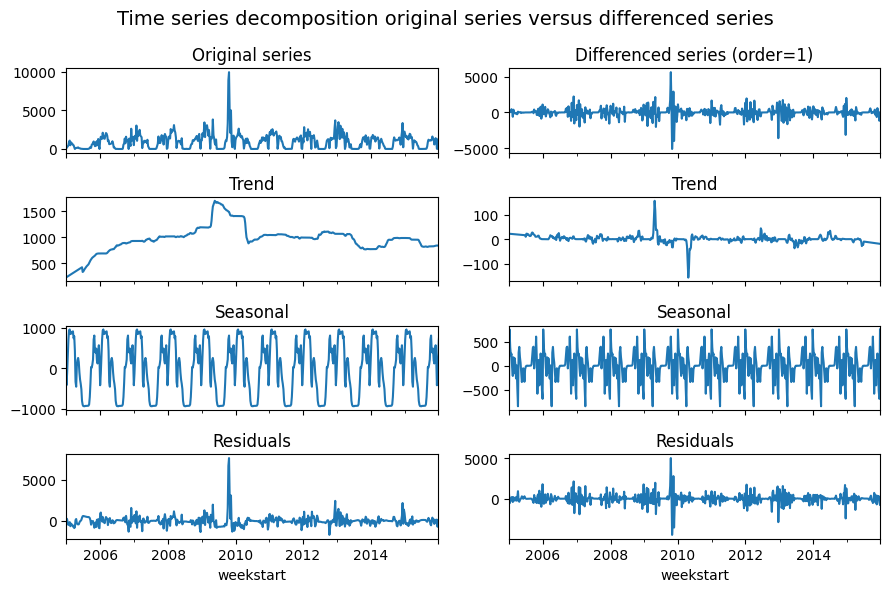

In [41]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(df['cases'], model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(df_diff_1['cases'], model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time series decomposition original series versus differenced series', fontsize=14)
fig.tight_layout()

In [42]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
model = SARIMAX(endog = df_train['cases'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 52))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")

model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              cases   No. Observations:                  575
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -4147.086
Date:                            Mon, 22 Jan 2024   AIC                           8304.172
Time:                                    13:03:29   BIC                           8325.461
Sample:                                12-26-2004   HQIC                          8312.510
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5585      0.014     38.554      0.000       0.530       0.587
ma.L1         -0.9999      0.406     -2.464      0.014      -1.795      -0.204
ar.S.L52       0.0612      0.034      1.814      0.070      -0.005       0.127
ma.S.L52      -0.9935      0.413     -2.406      0.016      -1.803      -0.184
sigma2      3.795e+05   8.89e-07   4.27e+11      0.000     3.8e+05     3.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):              9251.33
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             2.40
Prob(H) (two-sided):                  0.01   Kurtosis:                        23.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+28. Standard errors may be unstable.
"""

In [43]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(df_test['cases'])).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

2016-01-03     937.348752
2016-01-10    1437.923204
2016-01-17    1826.629476
2016-01-24    1900.924627
Freq: W-SUN, Name: predictions_statsmodels, dtype: float64

In [46]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
            )
forecaster.fit(y=df_train['cases'], suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(df_test))
predictions.head(4)

2016-01-03     937.348752
2016-01-10    1437.923204
2016-01-17    1826.629476
2016-01-24    1900.924627
Freq: W-SUN, Name: pred, dtype: float64

In [53]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor=Sarimax(
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 52),
                            maxiter=100
                        )
            )

metric, predictions = backtesting_sarimax(
                        forecaster            = forecaster,
                        y                     = df['cases'][:end_validation],
                        initial_train_size    = len(df_train),
                        fixed_train_size      = False,
                        steps                 = 6,
                        metric                = 'mean_absolute_error',
                        refit                 = True,
                        n_jobs                = "auto",
                        suppress_warnings_fit = True,
                        verbose               = True,
                        show_progress         = True
                    )

print(f"Metric (mean_absolute_error): {metric}")
display(predictions.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 575
Number of observations used for backtesting: 105
    Number of folds: 18
    Number of steps per fold: 6
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2004-12-26 00:00:00 -- 2015-12-27 00:00:00  (n=575)
    Validation: 2016-01-03 00:00:00 -- 2016-02-07 00:00:00  (n=6)
Fold: 1
    Training:   2004-12-26 00:00:00 -- 2016-02-07 00:00:00  (n=581)
    Validation: 2016-02-14 00:00:00 -- 2016-03-20 00:00:00  (n=6)
Fold: 2
    Training:   2004-12-26 00:00:00 -- 2016-03-20 00:00:00  (n=587)
    Validation: 2016-03-27 00:00:00 -- 2016-05-01 00:00:00  (n=6)
Fold: 3
    Training:   2004-12-26 00:00:00 -- 2016-05-01 00:00:00  (n=593)
    Validation: 2016-05-08 00:00:00 -- 2016-06-12 00:00:00  (n=6)
Fold: 4
    Training:   2004-12-26 00:00:00 -- 2016-06-12 00:00:00  (n=599)

100%|██████████| 18/18 [55:45<00:00, 185.86s/it]


Metric (mean_absolute_error): 281.46405074184133


,pred
2016-01-03,937.348752
2016-01-10,1437.923204
2016-01-17,1826.629476
2016-01-24,1900.924627


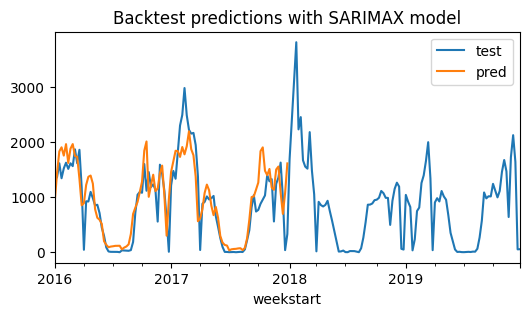

In [54]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df.loc[end_train:]['cases'].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend()

In [56]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor=Sarimax(order=(1, 1, 1), maxiter=500), # Placeholder replaced in the grid search
            )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 52), (1, 1, 1, 52)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                forecaster            = forecaster,
                y                     = df['cases'].loc[:end_validation],
                param_grid            = param_grid,
                steps                 = 6,
                refit                 = True,
                metric                = 'mean_absolute_error',
                initial_train_size    = len(df_train),
                fixed_train_size      = False,
                return_best           = False,
                n_jobs                = 'auto',
                suppress_warnings_fit = True,
                verbose               = False,
                show_progress         = True
            )

results_grid.head(5)

Number of models compared: 45.


params grid: 100%|██████████| 45/45 [7:08:10<00:00, 570.90s/it]   


,params,mean_absolute_error,order,seasonal_order,trend
30,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",188.346211,"(1, 1, 1)","(0, 1, 0, 52)",None
31,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",188.346211,"(1, 1, 1)","(0, 1, 0, 52)",n
40,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",192.403898,"(2, 1, 1)","(0, 1, 0, 52)",n
39,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",192.403898,"(2, 1, 1)","(0, 1, 0, 52)",None
41,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",243.226495,"(2, 1, 1)","(0, 1, 0, 52)",c


In [58]:
forecaster_copy = forecaster

In [62]:
metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = df['cases'],
                                initial_train_size    = len(df.loc[:end_validation]),
                                steps                 = 6,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = 1,
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )